# Gimbal Lookup Table Calculator

This notebook gives tools to create a lookup table for each gimbal position. This lookup table is 2 dimensional where each axis describes a component of the command angle. The value associated with this position on the lookup table is a pair of servo commands which orient the gimbal into the command position.

This algorithm will first traverse all the possible servo angles and then output a table which represents the servo commands to gimbal position.

Currently this script is in it's primitive phase and only computes a gimbal angle for given servo commands.

© 2025 Ronan Howard. All rights reserved

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# positions
S_ca = np.array([14.5282132153,-23.6498906926,11.654])
S_cb = np.array([-23.6498906926,14.5282132153,11.654])
r_S = 4.45
r_arm = 22.8336

# reference gimbal position
G_A_ref = np.array([22.555, 0, 15.8])
G_B_ref = np.array([0, 22.555, 15.8])
theta_0 = 69.91886


In [3]:
def find_orientation(t_A, t_B):
    theta_A = np.radians(t_A + theta_0)
    theta_B = np.radians(t_B + theta_0)

    S_A = S_ca + r_S * np.array([np.sin(theta_A), np.cos(theta_A), 0])
    S_B = S_cb + r_S * np.array([np.cos(theta_B), np.sin(theta_B), 0])

    # opptimization function
    def error(q):
        R = Rotation.from_quat(q).as_matrix()
        G_A = R @ G_A_ref
        G_B = R @ G_B_ref
        return (np.linalg.norm(G_A-S_A)-r_arm)**2 + (np.linalg.norm(G_B-S_B)-r_arm)**2

    # quaternion constraint
    def constraint(q):
        return q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2 - 1  # ||q|| = 1

    cons = {'type': 'eq', 'fun': constraint}

    # make initial guess (always starts with flush position)
    q0 = np.array([0,0,0,1]) # identity quaternion
    result = minimize(error, q0, method='SLSQP', constraints=cons)
    q_opt = result.x
    return Rotation.from_quat(q_opt).as_matrix()


def visualize_orientation(R):
    v = R @ [0,0,1]
    print(v)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(0,0,0, v[0], v[1], v[2])
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([0, 1])
    plt.show()

[-0.16498388 -0.15395305  0.97420674]


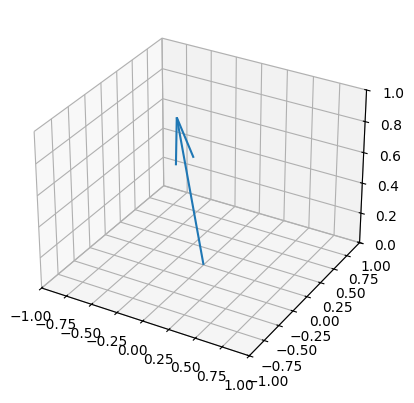

In [5]:
visualize_orientation(find_orientation(30,30))